In [ ]:
import os
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'

# Handling Long Sequence by Chunking
## Plan
1. We will split the entire text into sentences.
2. Calculate the embedding of each sentence.
3. Calculate the whole text embedding by averaging the embeddings of each sentence.
4. Pass the whole text embedding to the fully connected layer for text classification.

## Data Preparation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from datasets import load_dataset
import nltk
from transformers import BertTokenizer, BertModel

# IMDB Dataset preparation
imdb_data = load_dataset('imdb')

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# tokenizer.pad_token = tokenizer.eos_token

class IMDBDataset(Dataset):
    def __init__(self, data, tokenizer, max_sentence_length=48):
        self.data = data
        self.tokenizer = tokenizer
        self.max_sentence_length = max_sentence_length

    def __len__(self):
        return len(self.data)

    
    def __getitem__(self, idx):
        text = self.data[idx]['text']
        label = self.data[idx]['label']
        # splitting the text into sentences
        sentences = nltk.sent_tokenize(text)
        # input_ids is the list of `input_ids` for each sentence
        input_ids = [tokenizer.encode(sentence, max_length=self.max_sentence_length, truncation=True, padding='max_length') for sentence in sentences]
        # attention_masks is the list of `attention_masks` for each sentence
        attention_masks = [[1 if token_id != tokenizer.pad_token_id else 0 for token_id in sentence] for sentence in input_ids]
        return {'input_ids': torch.tensor(input_ids, dtype=torch.long),
                'attention_mask': torch.tensor(attention_masks, dtype=torch.long),
                'label': torch.tensor(label, dtype=torch.long)}

# We are just training with 10% of overall dataset. I am doing training in my laptop (Mac M2), which has just 30 core GPU and 32 GB RAM
train_dataset = IMDBDataset(imdb_data['train'], tokenizer)
test_dataset = IMDBDataset(imdb_data['test'], tokenizer)

train_10_percent = int(len(train_dataset) * 0.1)
test_10_percent = int(len(test_dataset) * 0.1)

# Calculate the number of samples for the remaining 90%
train_90_percent = len(train_dataset) - train_10_percent
test_90_percent = len(test_dataset) - test_10_percent

# Split the datasets into 10% and 90%
train_data_10_percent, _ = random_split(train_dataset, [train_10_percent, train_90_percent])
test_data_10_percent, _ = random_split(test_dataset, [test_10_percent, test_90_percent])





Found cached dataset imdb (/Users/premtimsina/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

### pad_collate
**What we are doing here?**
If you choose a batch size of 4, Pytorch requires that the number of sentences in each sample for that batch should be the same. However, this is not the case in real life. In a batch of size 4, sample 1 could have 10 sentences, and sample 2 could have 13 sentences.

Therefore, in the pad_collate function, we perform padding on the sentences. We calculate the maximum number of sentences in that batch and pad accordingly.

In [ ]:


def pad_collate(batch):
    # calculate the maximum number of sentences in that batch
    max_num_sentences = max([item['input_ids'].shape[0] for item in batch])

    input_ids_batch = []
    attention_masks_batch = []

    # looping through each sample through batch. if batch_size =4; the following code loops for 4 times
    for item in batch:
        num_sentences = item['input_ids'].shape[0]
        pad_length = max_num_sentences - num_sentences
        input_ids = torch.cat([item['input_ids'], torch.zeros(pad_length, item['input_ids'].shape[1], dtype=torch.long)], dim=0)
        attention_mask = torch.cat([item['attention_mask'], torch.zeros(pad_length, item['attention_mask'].shape[1], dtype=torch.long)], dim=0)

        input_ids_batch.append(input_ids)
        attention_masks_batch.append(attention_mask)

    # it is just converting list into tensor by stacking along the dim=0
    input_ids_tensor = torch.stack(input_ids_batch, dim=0)
    attention_masks_tensor = torch.stack(attention_masks_batch, dim=0)
    labels_tensor = torch.tensor([item['label'] for item in batch], dtype=torch.long)

    return {'input_ids': input_ids_tensor, 'attention_mask': attention_masks_tensor, 'label': labels_tensor}

train_loader = DataLoader(train_data_10_percent, batch_size=4, shuffle=True, collate_fn=pad_collate)
test_loader = DataLoader(test_data_10_percent, batch_size=4, shuffle=True, collate_fn=pad_collate)

In [ ]:
item=next(iter(train_loader))


### We are just looking at the shape of data.
1. This signifies that batch_size=4, max_sentences inthat batch=21, max_seq_len=48

In [ ]:
print('input_ids', item['input_ids'].shape)
print('attention_mask', item['attention_mask'].shape)
print('label', item['label'].shape)

input_ids torch.Size([4, 21, 48])
attention_mask torch.Size([4, 21, 48])
label torch.Size([4])


In [ ]:
print(item['input_ids'])

tensor([[[ 101, 1045, 2031,  ...,    0,    0,    0],
         [ 101, 5735, 2001,  ...,    0,    0,    0],
         [ 101, 2200, 3422,  ...,    0,    0,    0],
         [ 101, 2748, 2009,  ...,    0,    0,    0],
         [   0,    0,    0,  ...,    0,    0,    0],
         [   0,    0,    0,  ...,    0,    0,    0]],

        [[ 101, 2044, 2108,  ..., 1000, 3458,  102],
         [ 101, 2349, 2000,  ..., 2521, 2682,  102],
         [ 101, 2023, 3576,  ...,    0,    0,    0],
         [ 101, 2009, 2471,  ...,    0,    0,    0],
         [ 101, 2174, 1010,  ..., 2477, 1007,  102],
         [   0,    0,    0,  ...,    0,    0,    0]],

        [[ 101, 2054, 2001,  ...,    0,    0,    0],
         [ 101, 2076, 1996,  ..., 2787, 2008,  102],
         [ 101, 2306, 1017,  ...,    0,    0,    0],
         [ 101, 1045, 2179,  ...,    0,    0,    0],
         [ 101, 1996, 2047,  ...,    0,    0,    0],
         [ 101, 2006, 2028,  ..., 2028, 2008,  102]],

        [[ 101, 2023, 2003,  ...,    0, 

### Model Architecture
1. forward(self, input_ids_list, attention_mask_list): This method defines the forward pass of the neural network. It takes two arguments: input_ids_list and attention_mask_list, which are lists of input IDs and attention masks for each input sentence, respectively.

2. The nested loops iterate through the batches and sentences within the batches. For each sentence, the BERT model is applied, and the 'pooler_output' is extracted, which is a fixed-size representation of the input text. The pooled outputs for each sentence are then stacked into a single tensor and averaged along the first dimension.

3. The batch_pooled_outputs list is then converted into a tensor using torch.stack().


4. The final fully connected (linear) layer is applied to produce the classification logits.

5. The FineTunedBertClassifier class is designed to handle variable-length input sequences by processing them sentence by sentence and averaging their pooled outputs. This approach can handle different numbers of sentences per batch and allows the model to be fine-tuned on a specific classification task.

In [ ]:
class FineTunedBertClassifier(nn.Module):
    def __init__(self, n_classes):
        super(FineTunedBertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids_list, attention_mask_list):
        batch_pooled_outputs = []

        # Loop through each sample in a batch
        for batch_input_ids, batch_attention_mask in zip(input_ids_list, attention_mask_list):
            pooled_outputs = []
            
            # Loop through each sentence within the sample
            # pooler_output is the sentence representation: output['pooler_output'] is the sentence embedding in case of bert
            for input_ids, attention_mask in zip(batch_input_ids, batch_attention_mask):
                output = self.bert(input_ids=input_ids.unsqueeze(0), attention_mask=attention_mask.unsqueeze(0))
                pooler_output = output['pooler_output']
                pooled_outputs.append(pooler_output)
            
            # Stack the pooled outputs into a single tensor
            pooled_outputs_tensor = torch.stack(pooled_outputs, dim=1)
            
            # Compute the mean along the first dimension (dim=1)
            concatenated_output = torch.mean(pooled_outputs_tensor, dim=1)
            batch_pooled_outputs.append(concatenated_output)

        # Stack the batch_pooled_outputs into a single tensor
        batch_pooled_outputs_tensor = torch.stack(batch_pooled_outputs, dim=0)
        
        output = self.dropout(batch_pooled_outputs_tensor)
        
        output = torch.squeeze(output, dim=1)

        return self.fc(output)

The above code may looks confusing. Thus, lets understand through the example. It's important to understand that the following example is just to explain the architecture of model. Our IMDB data_set dimension is diffrent than following example.

1. Suppose, input_ids_list and attention_mask_list looks like below. 
```
input_ids_list = [
    [  # sample 1
        [101, 2023, 2003, 1037, 2742, 102],  # Sentence 1: "This is a sample."
        [101, 1045, 2066, 2026, 3835, 102]   # Sentence 2: "I like my coffee."
    ],
    [  # sample 2
        [101, 1045, 2572, 1037, 3076, 102],  # Sentence 1: "I am a student."
        [101, 2026, 3899, 2003, 2307, 102]   # Sentence 2: "My dog is great."
    ]
]
```
```
attention_mask_list = [
    [  # sample 1
        [1, 1, 1, 1, 1, 1],  # Attention mask for sentence 1
        [1, 1, 1, 1, 1, 1]   # Attention mask for sentence 2
    ],
    [  # sample 2
        [1, 1, 1, 1, 1, 1],  # Attention mask for sentence 1
        [1, 1, 1, 1, 1, 1]   # Attention mask for sentence 2
    ]
]
```
2. pooled Output looks like


```
pooled_outputs = [
    [tensor_1_1],  # pooler_output for Batch 1, Sentence 1
    [tensor_1_2]   # pooler_output for Batch 1, Sentence 2
]

```
Here, tensor_1_1 and tensor_1_2 are tensors of shape (1, 768) representing the pooled outputs (fixed-size sentence embeddings) for the two sentences in the first batch.

When you execute pooled_outputs_tensor = torch.stack(pooled_outputs, dim=1), it stacks the pooled output tensors along dimension 1. The resulting pooled_outputs_tensor would have the shape (1, 2, 768):

```
[
    [
        [tensor_1_1],  # pooler_output for Batch 1, Sentence 1
        [tensor_1_2]   # pooler_output for Batch 1, Sentence 2
    ]
]

```
3. 
In the example, the pooled_outputs_tensor has a shape of (1, 2, 768), where the first dimension corresponds to the batch, the second dimension corresponds to the sentences within the batch, and the third dimension corresponds to the hidden size of the BERT model's output.

The line concatenated_output = torch.mean(pooled_outputs_tensor, dim=1) computes the mean of the pooled_outputs_tensor along dimension 1 (i.e., the sentences dimension). By doing this, we are effectively averaging the sentence embeddings within each batch. The result is a single tensor representing the entire batch, with a shape of (1, 768).

In this specific example, the concatenated_output tensor would be:
```
[
    [tensor_mean_1]  # Mean of pooled_outputs for Batch 1 (shape: (1, 768))
]

```

4. batch_pooled_outputs


```
batch_pooled_outputs = [
    [tensor_mean_1],  # Averaged sentence representation for sample 1
    [tensor_mean_2]   # Averaged sentence representation for sample 2
]

```

5. Finally Batched Pooled Output is send to the fully connected layer of classification

In [ ]:
len(train_loader)

625

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from datasets import load_dataset
from accelerate import Accelerator
from tqdm import tqdm

accelerator = Accelerator()
device = accelerator.device

model = FineTunedBertClassifier(n_classes=2)
optimizer = optim.Adam(model.parameters(), lr=1e-5)

model, optimizer = accelerator.prepare(model, optimizer)

criterion = nn.CrossEntropyLoss()

train_loader, test_loader = accelerator.prepare(train_loader, test_loader)
# We are saving the intermediate model after every 100 batches.
# This is a good practice if you have to train the model for many epochs.
# There could be system failures or other issues.
# Thus, you can restart your training from where you left off.
# Adjust the save interval based on your needs.
save_interval=100

# Training loop
num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    train_loader_progress = tqdm(enumerate(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}, Training", total=len(train_loader))
    for batch_idx, batch in train_loader_progress:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        accelerator.backward(loss)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        if batch_idx % 10 == 0:
            train_loader_progress.set_postfix(loss=loss.item())
        if (batch_idx + 1) % save_interval == 0:
            model_save_path = f"/Users/premtimsina/Documents/bpbbook/chapter6/model/AlbertTextClassifier_epoch{epoch + 1}_batch{batch_idx + 1}.pt"
            torch.save(model.state_dict(), model_save_path)
    model.eval()
    total_correct = 0
    total_samples = 0
    test_loader_progress = tqdm(test_loader, desc=f"Epoch {epoch + 1}/{num_epochs}, Testing")

    with torch.no_grad():
        for batch in test_loader_progress:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            logits = model(input_ids, attention_mask)
            _, preds = torch.max(logits, dim=1)
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = total_correct / total_samples
    print(f"Epoch {epoch + 1}/{num_epochs}, Accuracy: {accuracy:.4f}")

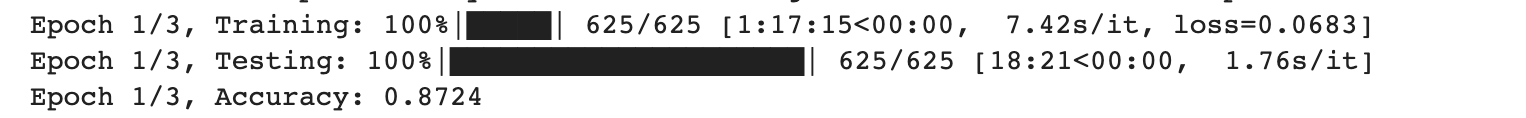

#Analysis
This is awesome. With just 10% of the dataset and only 1 epoch, we obtained an accuracy of 87%. I think the maximum accuracy for the IMDB dataset is around 96%. You could train the above model with the full dataset and a larger number of epochs to get even better result.

# Hierirchal Attention
## Plan
1. Hierarchical attention: This model uses a two-level hierarchical attention mechanism:
  * Local attention: Applied to individual sentences in a document to create sentence representations.
  * Global attention: Applied to sentence representations to create a document representation.


## Data preparation
The data preparation is exactly similar to data preparation we did above.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from datasets import load_dataset
import nltk
from transformers import BertTokenizer, BertModel

# IMDB Dataset preparation
imdb_data = load_dataset('imdb')

from transformers import AlbertTokenizer

tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")

class IMDBDataset(Dataset):
    def __init__(self, data, tokenizer, max_sentence_length=48):
        self.data = data
        self.tokenizer = tokenizer
        self.max_sentence_length = max_sentence_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data[idx]['text']
        label = self.data[idx]['label']
        sentences = nltk.sent_tokenize(text)
        input_ids = [tokenizer.encode(sentence, max_length=self.max_sentence_length, truncation=True, padding='max_length') for sentence in sentences]
        attention_masks = [[1 if token_id != tokenizer.pad_token_id else 0 for token_id in sentence] for sentence in input_ids]
        return {'input_ids': torch.tensor(input_ids, dtype=torch.long),
                'attention_mask': torch.tensor(attention_masks, dtype=torch.long),
                'label': torch.tensor(label, dtype=torch.long)}

train_dataset = IMDBDataset(imdb_data['train'], tokenizer)
test_dataset = IMDBDataset(imdb_data['test'], tokenizer)

train_5_percent = int(len(train_dataset) * 0.05)
test_5_percent = int(len(test_dataset) * 0.05)

# Calculate the number of samples for the remaining 90%
train_95_percent = len(train_dataset) - train_5_percent
test_95_percent = len(test_dataset) - test_5_percent

# Split the datasets into 10% and 90%
train_data_5_percent, _ = random_split(train_dataset, [train_5_percent, train_95_percent])
test_data_5_percent, _ = random_split(test_dataset, [test_5_percent, test_95_percent])

def pad_collate(batch):
    max_num_sentences = max([item['input_ids'].shape[0] for item in batch])

    input_ids_batch = []
    attention_masks_batch = []

    for item in batch:
        num_sentences = item['input_ids'].shape[0]
        pad_length = max_num_sentences - num_sentences
        input_ids = torch.cat([item['input_ids'], torch.zeros(pad_length, item['input_ids'].shape[1], dtype=torch.long)], dim=0)
        attention_mask = torch.cat([item['attention_mask'], torch.zeros(pad_length, item['attention_mask'].shape[1], dtype=torch.long)], dim=0)

        input_ids_batch.append(input_ids)
        attention_masks_batch.append(attention_mask)

    input_ids_tensor = torch.stack(input_ids_batch, dim=0)
    attention_masks_tensor = torch.stack(attention_masks_batch, dim=0)
    labels_tensor = torch.tensor([item['label'] for item in batch], dtype=torch.long)

    return {'input_ids': input_ids_tensor, 'attention_mask': attention_masks_tensor, 'label': labels_tensor}

train_loader = DataLoader(train_data_5_percent, batch_size=2, shuffle=True, collate_fn=pad_collate)
test_loader = DataLoader(test_data_5_percent, batch_size=2, shuffle=True, collate_fn=pad_collate)



Found cached dataset imdb (/Users/premtimsina/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
len(train_loader)

625

## 2.2. Model Architecture

In [ ]:
from transformers import AlbertModel

class AlbertTextClassifier(nn.Module):
    def __init__(self, num_classes):
        super(AlbertTextClassifier, self).__init__()
        self.albert = AlbertModel.from_pretrained("albert-base-v2")
        self.attention = nn.Linear(self.albert.config.hidden_size, 1)
        self.classifier = nn.Linear(self.albert.config.hidden_size, num_classes)
        self.dropout = nn.Dropout(0.1)

    def forward(self, input_ids, attention_mask):
        batch_size, num_sentences, seq_len = input_ids.shape
        input_ids = input_ids.view(batch_size * num_sentences, seq_len)
        attention_mask = attention_mask.view(batch_size * num_sentences, seq_len)

        outputs = self.albert(input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state
        attention_weights = torch.softmax(self.attention(hidden_states), dim=1)
        sentence_representation = torch.sum(attention_weights * hidden_states, dim=1)
        sentence_representation = sentence_representation.view(batch_size, num_sentences, -1)

        doc_attention_weights = torch.softmax(self.attention(sentence_representation), dim=1)
        doc_representation = torch.sum(doc_attention_weights * sentence_representation, dim=1)
        doc_representation = self.dropout(doc_representation)  # Add dropout

        logits = self.classifier(doc_representation)
        return logits


###The above code might be confusing: Let's explain through example:
Assume we have the following input:

  * 2 documents (batch_size = 2)
  * Each document has 3 sentences (num_sentences = 3)
  * Each sentence has 4 tokens (seq_len = 4)
  * The input data would have the following dimensions:
  ```
  input_ids: (2, 3, 4)
  attention_mask: (2, 3, 4)
  ```
Now, let's walk through the processing steps:

1. Reshape input_ids and attention_mask:
  ```
  input_ids: (6, 4) [2 * 3 = 6, #since we have 2 documents with 3 sentences each]
  attention_mask: (6, 4)
  ```
2. Pass input_ids and attention_mask to the ALBERT model:

  * Obtain hidden_states with dimensions (6, 4, hidden_size)
  * Compute attention weights for each token:

3. Apply self.attention to hidden_states, resulting in a tensor of shape (6, 4, 1)
4. Apply softmax to compute attention_weights: (6, 4, 1)
5. Calculate sentence representations:

  * Multiply attention_weights with hidden_states (element-wise): (6, 4, hidden_size)
  * Sum along the sequence dimension (dim=1): (6, hidden_size)
  * Reshape the tensor to (2, 3, hidden_size)

6. Compute document-level attention weights:

  * Apply self.attention to sentence_representation, resulting in a tensor of shape (2, 3, 1)
  * Apply softmax to compute doc_attention_weights: (2, 3, 1)
7. Calculate document representations:

  * Multiply doc_attention_weights with sentence_representation (element-wise): (2, 3, hidden_size)
  * Sum along the sentences dimension (dim=1): (2, hidden_size)
  * Apply dropout to the document representations:

8. doc_representation: (2, hidden_size)
9. Pass the document representation through the classifier layer:


## 2.3. Training loop

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from datasets import load_dataset
from accelerate import Accelerator
from tqdm import tqdm

accelerator = Accelerator()
device = accelerator.device

model = AlbertTextClassifier(num_classes=2)
optimizer = optim.Adam(model.parameters(), lr=1e-5)

model, optimizer = accelerator.prepare(model, optimizer)

criterion = nn.CrossEntropyLoss()

train_loader, test_loader = accelerator.prepare(train_loader, test_loader)
save_interval=100

# Training loop
num_epochs = 1

for epoch in range(num_epochs):
    model.train()
    train_loader_progress = tqdm(enumerate(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}, Training", total=len(train_loader))
    for batch_idx, batch in train_loader_progress:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        accelerator.backward(loss)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        if batch_idx % 10 == 0:
            train_loader_progress.set_postfix(loss=loss.item())
        if (batch_idx + 1) % save_interval == 0:
            model_save_path = f"/Users/premtimsina/Documents/bpbbook/chapter6/model/AlbertTextClassifier_epoch{epoch + 1}_batch{batch_idx + 1}.pt"
            torch.save(model.state_dict(), model_save_path)
    model.eval()
    total_correct = 0
    total_samples = 0
    test_loader_progress = tqdm(test_loader, desc=f"Epoch {epoch + 1}/{num_epochs}, Testing")

    with torch.no_grad():
        for batch in test_loader_progress:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            logits = model(input_ids, attention_mask)
            _, preds = torch.max(logits, dim=1)
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = total_correct / total_samples
    print(f"Epoch {epoch + 1}/{num_epochs}, Accuracy: {accuracy:.4f}")

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertModel: ['predictions.dense.bias', 'predictions.dense.weight', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.weight', 'predictions.decoder.bias', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Epoch 1/1, Testing: 100%|█████████████████████| 625/625 [00:44<00:00, 14.15it/s]

Epoch 1/1, Accuracy: 0.8688


It's awesome, we obtained 86% accuracy which is similar to document chuncking approach